<a href="https://colab.research.google.com/github/jiukeem/deeplearning_from_scratch/blob/master/mini_batch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [3]:
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
y = y.reshape(-1, 1)
y.shape

(569, 1)

In [4]:
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [5]:
print('shape of x_train: {}'.format(x_train.shape))
print('shape of y_train: {}'.format(y_train.shape))
print('shape of x_val: {}'.format(x_val.shape))
print('shape of x_test: {}'.format(x_test.shape))

shape of x_train: (364, 30)
shape of y_train: (364, 1)
shape of x_val: (91, 30)
shape of x_test: (114, 30)


In [6]:
mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)

In [7]:
x_train_scaled = (x_train - mean) / std
x_val_scaled = (x_val - mean) / std
x_test_scaled = (x_test - mean) / std


In [17]:
class DualLayer:
  def __init__(self, learning_rate=0.1, num_of_node=10, l2_lambda=0, batch_size=32):
    self.W1 = None
    self.b1 = None
    self.W2 = None
    self.b2 = None
    self.lr = learning_rate
    self.node = num_of_node
    self.cost_history = []
    self.l2 = l2_lambda
    self.val_cost_history = []
    self.batch = batch_size

  def initialization(self, X):
    np.random.seed(42) # 실전에서는 필요없따
    self.W1 = np.random.normal(0, 1, (X.shape[1], self.node))
    self.b1 = np.zeros((1, self.node))
    self.W2 = np.random.normal(0, 1, (self.node, 1))
    self.b2 = 0
    return self.W1, self.b1, self.W2, self.b2 

  def gen_batch(self, X, Y):
    num = X.shape[0] // self.batch
    if X.shape[0] % self.batch:
      num += 1
    index = np.random.permutation(np.arange(X.shape[0]))
    X = X[index]
    Y = Y[index]
    for i in range(num):
      start = i * self.batch
      end = (i + 1) * self.batch 
      yield X[start: end], Y[start: end] # 명시적으로 리스트를 만들지 않고 이터러블 가능한 무언가를 돌려줌
      # 아마도 메모리를 덜 잡아먹나? O
      # 리스트를 만들지 않으면서 필요한만큼 데이터를 추출할 수 있다.
            
  def sigmoid(self, Z):
    A = 1 / (1 + np.exp(-Z))
    return A

  def forward_prop(self, X):
    Z1 = np.dot(X, self.W1) + self.b1
    A1 = self.sigmoid(Z1)
    Z2 = np.dot(A1, self.W2) + self.b2
    A2 = self.sigmoid(Z2)
    cache = (Z1, A1, Z2)
    return A2, cache

  def backward_prop(self, X, Y, A2, cache):
    Z1, A1, Z2 = cache
    m = X.shape[0]
    dW2 = np.dot(A1.T, A2 - Y) / m + self.l2 * self.W2
    db2 = np.sum(A2 - Y) / m
    temp = np.dot(A2 - Y, self.W2.T) * A1 * (1 - A1)
    dW1 = np.dot(X.T, temp) / m + self.l2 * self.W1
    db1 = np.sum(temp, axis=0) / m
    gradient = (dW2, db2, dW1, db1)
    return gradient

  def undate_parameter(self, gradient):
    dW2, db2, dW1, db1 = gradient
    self.W2 -= dW2
    self.b2 -= db2
    self.W1 -= dW1
    self.b1 -= db1

  def calcul_cost(self, Y, A2):
    A2 = np.clip(A2, 1e-10, 1-1e-10)
    L = -(Y * np.log(A2) + (1 - Y) * np.log(1 - A2)) + self.l2
    regul = self.l2 / 2 * (np.sum(self.W1 ** 2) + np.sum(self.W2 ** 2))
    L += regul
    cost = np.sum(L) / Y.shape[0]
    return cost

  def fit(self, X, Y, epoch=100, X_val=None, Y_val=None):
    self.W1, self.b1, self.W2, self.b2 = self.initialization(X)
    for i in range(epoch):
      for X_batch, Y_batch in self.gen_batch(X, Y):
        A2, cache = self.forward_prop(X_batch)
        gradient = self.backward_prop(X_batch, Y_batch, A2, cache)
        self.undate_parameter(gradient)
        cost = self.calcul_cost(Y_batch, A2)
        self.cost_history.append(cost)
        self.update_val(X_val, Y_val)

  def update_val(self, X_val, Y_val):
    A2, _ = self.forward_prop(X_val)
    cost = self.calcul_cost(Y_val, A2)
    self.val_cost_history.append(cost)

  def predict(self, X, Y):
    A2, _ = self.forward_prop(X)
    return A2 > 0.5

  def score(self, X, Y):
    Y_hat = self.predict(X, Y)
    score = np.mean(Y_hat == Y)
    return score

In [18]:
layer = DualLayer(l2_lambda=0.001)
layer.fit(x_train_scaled, y_train, X_val=x_val_scaled, Y_val=y_val, epoch=500)

In [19]:
layer.score(x_val_scaled, y_val)

0.978021978021978

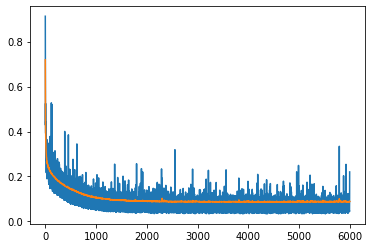

In [20]:
plt.plot(layer.cost_history)
plt.plot(layer.val_cost_history)
plt.show()

In [22]:
layer2 = DualLayer(l2_lambda=0.001, batch_size=128)
layer2.fit(x_train_scaled, y_train, X_val=x_val_scaled, Y_val=y_val, epoch=500)
layer2.score(x_val_scaled, y_val)

0.978021978021978

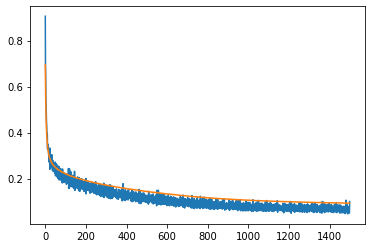

In [23]:
plt.plot(layer2.cost_history)
plt.plot(layer2.val_cost_history)
plt.show()

In [26]:
# 사이킷런으로 하려면
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, ), activation='logistic', solver='sgd', alpha=0.01, batch_size=32,\
                    learning_rate_init=0.1, max_iter=500)

In [27]:
mlp.fit(x_train_scaled, y_train)
mlp.score(x_val_scaled, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.989010989010989